# **Introduction**

Air pollution is affected by the weather due to the moisture and the precipitation of the air affecting the concentration of pollutants through factors such as humidity, temperature, and particulate matter. For example, when it rains, particulate matter such as PM 2.5 is carried out of the air through rain droplets into groundwater, and gaseous pollutants may dissolve into the water. 

We’re choosing the air particles PM 2.5 because the variable frequently emerges in regards to the air pollution in Beijing, specifically the region Tiantan because of its population consisting of both locals and tourists creating a generous amount of people to be affected by. Through this data analysis, we can predict the air condition in the region and the impact it has on the community and how we can further improve it. 

In this project, we will aim to predict the concentration of the air particles PM 2.5 based on the weather which is decided by 5 variables (the temperature (C°), pressure (hPa), dew point temperature (C°), precipitation (mm), wind speed (m/s)). A question that may come up within this prediction would relate to **how does the weather affect the concentration of pollutant PM 2.5 ?**

The dataset itself consists of hourly concentration of air pollutants and meteorological variables from 12 air-monitoring stations in Beijing between March 1, 2013 and February 28, 2017. 

# **Methods**

The object that we are going to predict in this data set is the pollutant PM 2.5 with the 5 predictors we're planning to apply which are Temperature (TEMP), Pressure (PRES), Dew Point Temperature (DEWP), Rain (RAIN). and Wind Speed (WSPM). We will perform a KNN regression on the data and analyze the strength of the effect that weather has on the concentration of pollutants. 

In the original data set, there is a variable called Wind Direction (wd) in which we will not take into consideration within the prediction since it is a categorical variable therefore is not integrated with the plot.

Additionally, seasonal weather may influence the prediction, however this is not our topic of study. Therefore all time variables such as year, month, day, hour are dropped to prevent interference with our regression plot although we will attempt to group the data points by year, month, and day.

We plan normalize our data to make sure that certain variables with large absolute quantities such as PM 2.5 do not receive undue weight.

In conclusion, the variables used for the data set are as such :
1. Objects for Regression: PM 2.5 
 
2. Predictors: 
- Temperature (TEMP) 
- Pressure (PRES) 
- Dew Point Temperature (DEWP) 
- Rain (RAIN) 
- Wind Speed (WSPM) 

We will visualize the results through a regression plot on pollutants such as PM 2.5 in which we will create separate regression plots for each predictor in relation to our pollutant.

## **Code**

### 1. Load the Library and Data

In [13]:
library(tidyverse)
library(repr)
options(repr.matrix.max.rows = 6)
library(testthat)
library(digest)
library(tidymodels)
library(GGally)
library(broom)
library(infer)
library(cowplot)

In [14]:
weather_data <- read.csv("https://www.dropbox.com/s/2vo6d6ynrsxpavp/PRSA_Data_Tiantan_20130301-20170228.csv?dl=1")
weather_data

No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
1,2013,3,1,0,6,6,4,8,300,81,-0.5,1024.5,-21.4,0,NNW,5.7,Tiantan
2,2013,3,1,1,6,29,5,9,300,80,-0.7,1025.1,-22.1,0,NW,3.9,Tiantan
3,2013,3,1,2,6,6,4,12,300,75,-1.2,1025.3,-24.6,0,NNW,5.3,Tiantan
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
35062,2017,2,28,21,18,32,4,48,500,48,10.8,1014.2,-13.3,0,NW,1.1,Tiantan
35063,2017,2,28,22,15,42,5,52,600,44,10.5,1014.4,-12.9,0,NNW,1.2,Tiantan
35064,2017,2,28,23,15,50,5,68,700,21,8.6,1014.1,-15.9,0,NNE,1.3,Tiantan


### 2. Tidy the Data

`summarise()` has grouped output by 'year', 'month'. You can override using the
`.groups` argument.


TEMP,PRES,DEWP,RAIN,WSPM,PM2.5
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.3250000,1028.783,-21.46667,0,3.3083333,8.62500
0.4916667,1028.850,-16.96250,0,0.7916667,31.70833
4.9875000,1016.458,-12.31250,0,1.2250000,98.04167
⋮,⋮,⋮,⋮,⋮,⋮
7.245833,1018.812,-10.754167,0,1.825000,10.20833
7.208333,1020.337,-8.258333,0,1.566667,24.16667
10.958333,1014.888,-12.783333,0,2.058333,14.87500


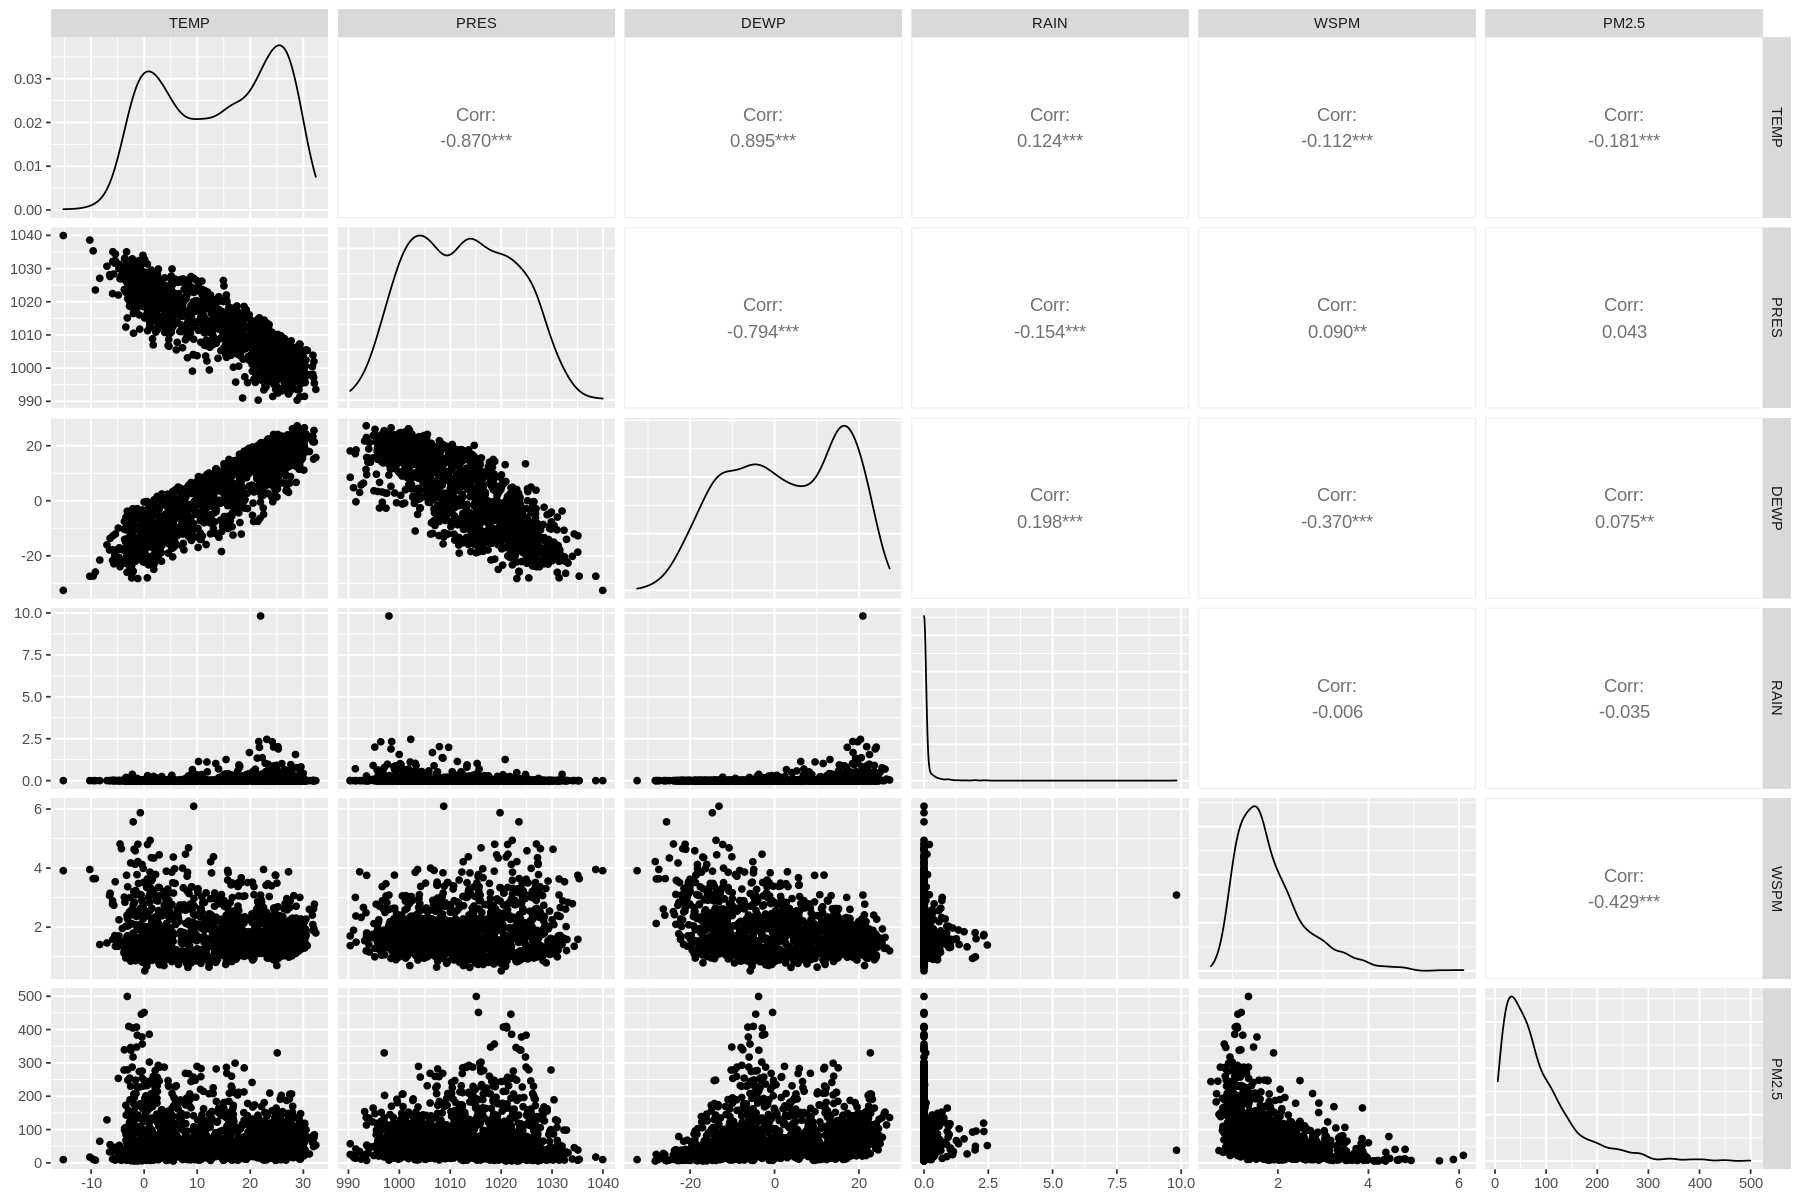

In [15]:
tidy_data <- weather_data |> group_by(year, month, day) |> 
summarize(TEMP = mean(TEMP), PRES = mean(PRES), DEWP = mean(DEWP), RAIN = mean(RAIN), WSPM = mean(WSPM), PM2.5 = mean(PM2.5)) |> ungroup() |> select(-year, -month, -day) |> na.omit()

options(repr.plot.height = 10, repr.plot.width = 15)
tidy_data
ggpairs(tidy_data)

**ELABORATION** 

After we loaded and the tidied up the data set in R, we decided to visualize it with the *ggpairs* function. Here we see in these graphs, that the relationship between the object of prediction, PM2.5 and its 5 predictors vary between one and the other, with each variable having its own relationship with one another. We can take a look specifically on the last row where there's a direct relationship between the variable PM2.5 with its predictors *Temperature, Pressure, Dew Point, Rain, and Wind Speed.*

On the final row, we can see that as the values of PM2.5 increases, the predictors have the relationships as such :
- The variable Temperature has a sudden jump in the beginning and then decreases to then remain stable throughout the rest of the graph.
- The variable Pressure has a stable rate throughout the graph with a few values increasing towards the middle-end.
- The variable Dew Point 
- The variable Rain
- The variable Wind Speed

### 3. KNN Regression

In [16]:
set.seed(2000) 

weather_split <- initial_split(tidy_data, prop = 0.75, strata = PM2.5)
weather_training <- training(weather_split)
weather_testing <- testing(weather_split)


weather_split
weather_training
weather_testing

<Training/Testing/Total>
<936/316/1252>

TEMP,PRES,DEWP,RAIN,WSPM,PM2.5
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.3250000,1028.783,-21.46667,0,3.3083333,8.62500
0.4916667,1028.850,-16.96250,0,0.7916667,31.70833
10.5625000,1019.454,-14.00000,0,2.5041667,22.33333
⋮,⋮,⋮,⋮,⋮,⋮
-1.420347,1017.919,-10.13333,0,1.4625000,347.4167
-0.575000,1019.250,-14.21667,0,0.9333333,178.0000
1.550000,1022.638,-12.79167,0,1.1083333,134.8333


TEMP,PRES,DEWP,RAIN,WSPM,PM2.5
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5.104167,1010.796,1.120833,0.2208333,1.179167,126.9583
3.962500,1023.471,-4.991667,0.0000000,1.858333,83.8750
5.866667,1016.388,-1.320833,0.0000000,0.937500,189.7083
⋮,⋮,⋮,⋮,⋮,⋮
1.541667,1016.742,-5.829167,0,0.8791667,208.29167
3.729167,1024.321,-12.325000,0,2.0291667,20.83333
7.208333,1020.337,-8.258333,0,1.5666667,24.16667


In [17]:
weather_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
                set_engine("kknn") |>
                set_mode("regression") 

weather_recipe <- recipe(PM2.5 ~ ., data = weather_training) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors())
weather_spec
weather_recipe

K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Recipe

Inputs:

      role #variables
   outcome          1
 predictor          5

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [18]:
set.seed(2000) 

weather_vfold <- vfold_cv(weather_training, v = 5, strata = PM2.5)

weather_workflow <- workflow() |>
                    add_recipe(weather_recipe) |>
                    add_model(weather_spec)
weather_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [19]:
set.seed(2000)

gridvals <- tibble(neighbors = seq(from = 1, to = 200))

weather_results <- weather_workflow |>
                  tune_grid(resamples = weather_vfold, grid = gridvals) |>
                  collect_metrics()

weather_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,64.9948030,5,3.26930251,Preprocessor1_Model001
1,rsq,standard,0.3762512,5,0.03825339,Preprocessor1_Model001
2,rmse,standard,56.8413364,5,2.27360818,Preprocessor1_Model002
⋮,⋮,⋮,⋮,⋮,⋮,⋮
199,rsq,standard,0.2619246,5,0.01694915,Preprocessor1_Model199
200,rmse,standard,63.1379714,5,3.95369597,Preprocessor1_Model200
200,rsq,standard,0.2620131,5,0.01685433,Preprocessor1_Model200


In [20]:
weather_min <- weather_results |>
    filter(.metric == "rmse") |>
    arrange(mean) |> 
    head(1)

weather_min

k_min <- weather_min |>
          pull(neighbors)

weather_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
          set_engine("kknn") |>
          set_mode("regression")

weather_best_fit <- workflow() |>
          add_recipe(weather_recipe) |>
          add_model(weather_best_spec) |>
          fit(data = weather_training)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
7,rmse,standard,51.39042,5,2.832289,Preprocessor1_Model007


.pred,TEMP,PRES,DEWP,RAIN,WSPM,PM2.5
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
102.98214,5.104167,1010.796,1.120833,0.2208333,1.179167,126.9583
95.27381,3.962500,1023.471,-4.991667,0.0000000,1.858333,83.8750
167.42262,5.866667,1016.388,-1.320833,0.0000000,0.937500,189.7083
⋮,⋮,⋮,⋮,⋮,⋮,⋮
254.38095,1.541667,1016.742,-5.829167,0,0.8791667,208.29167
51.25000,3.729167,1024.321,-12.325000,0,2.0291667,20.83333
54.02381,7.208333,1020.337,-8.258333,0,1.5666667,24.16667


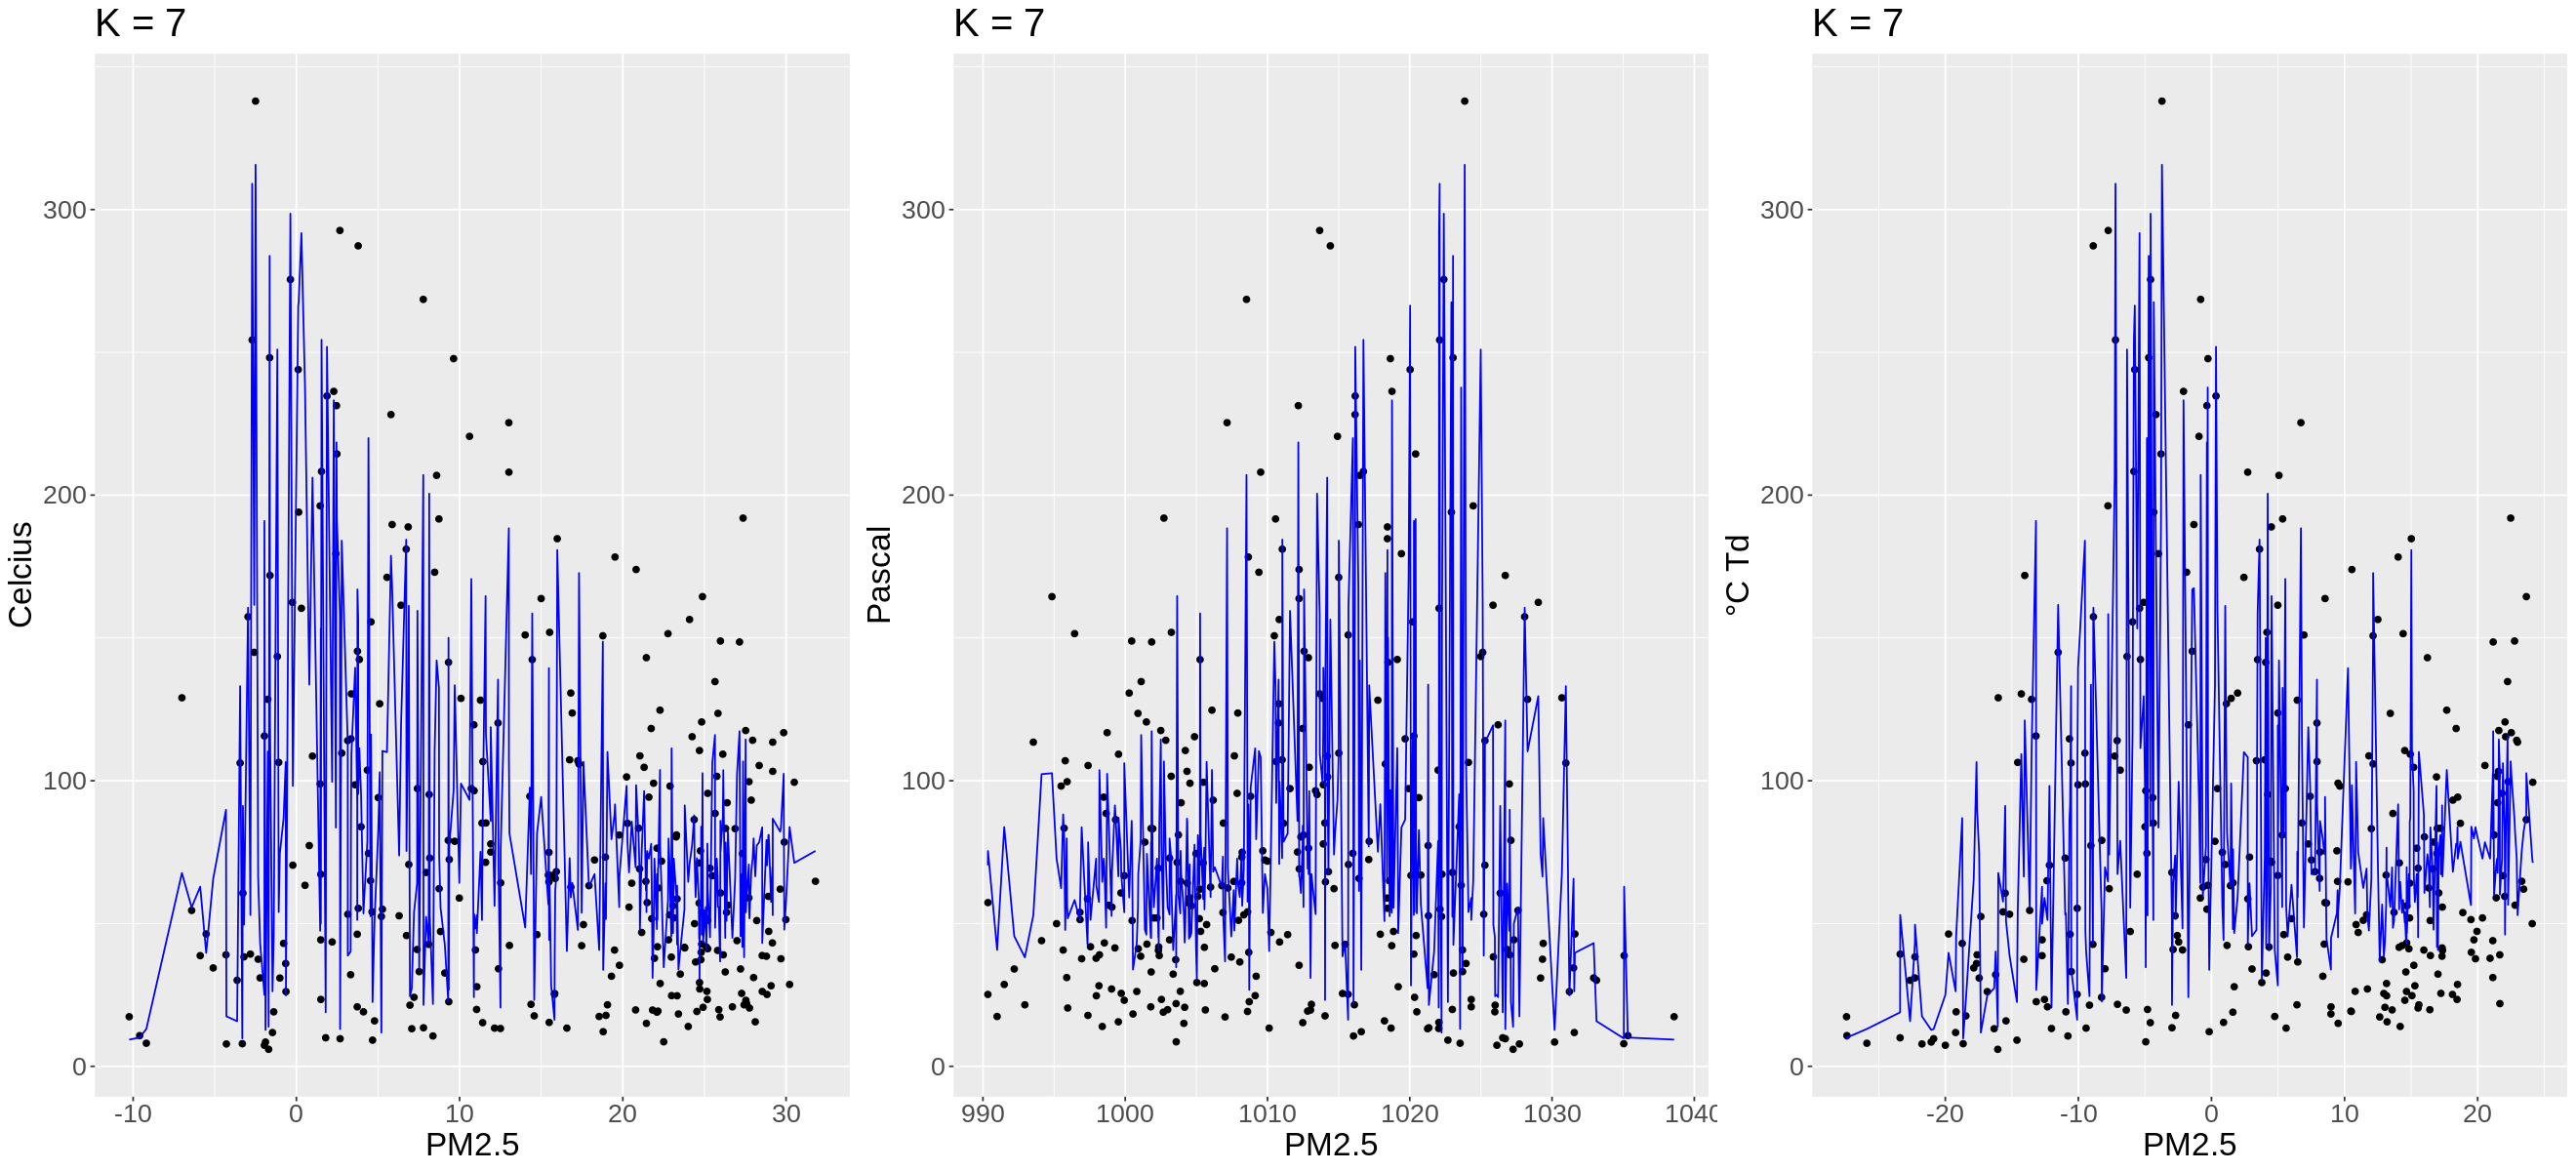

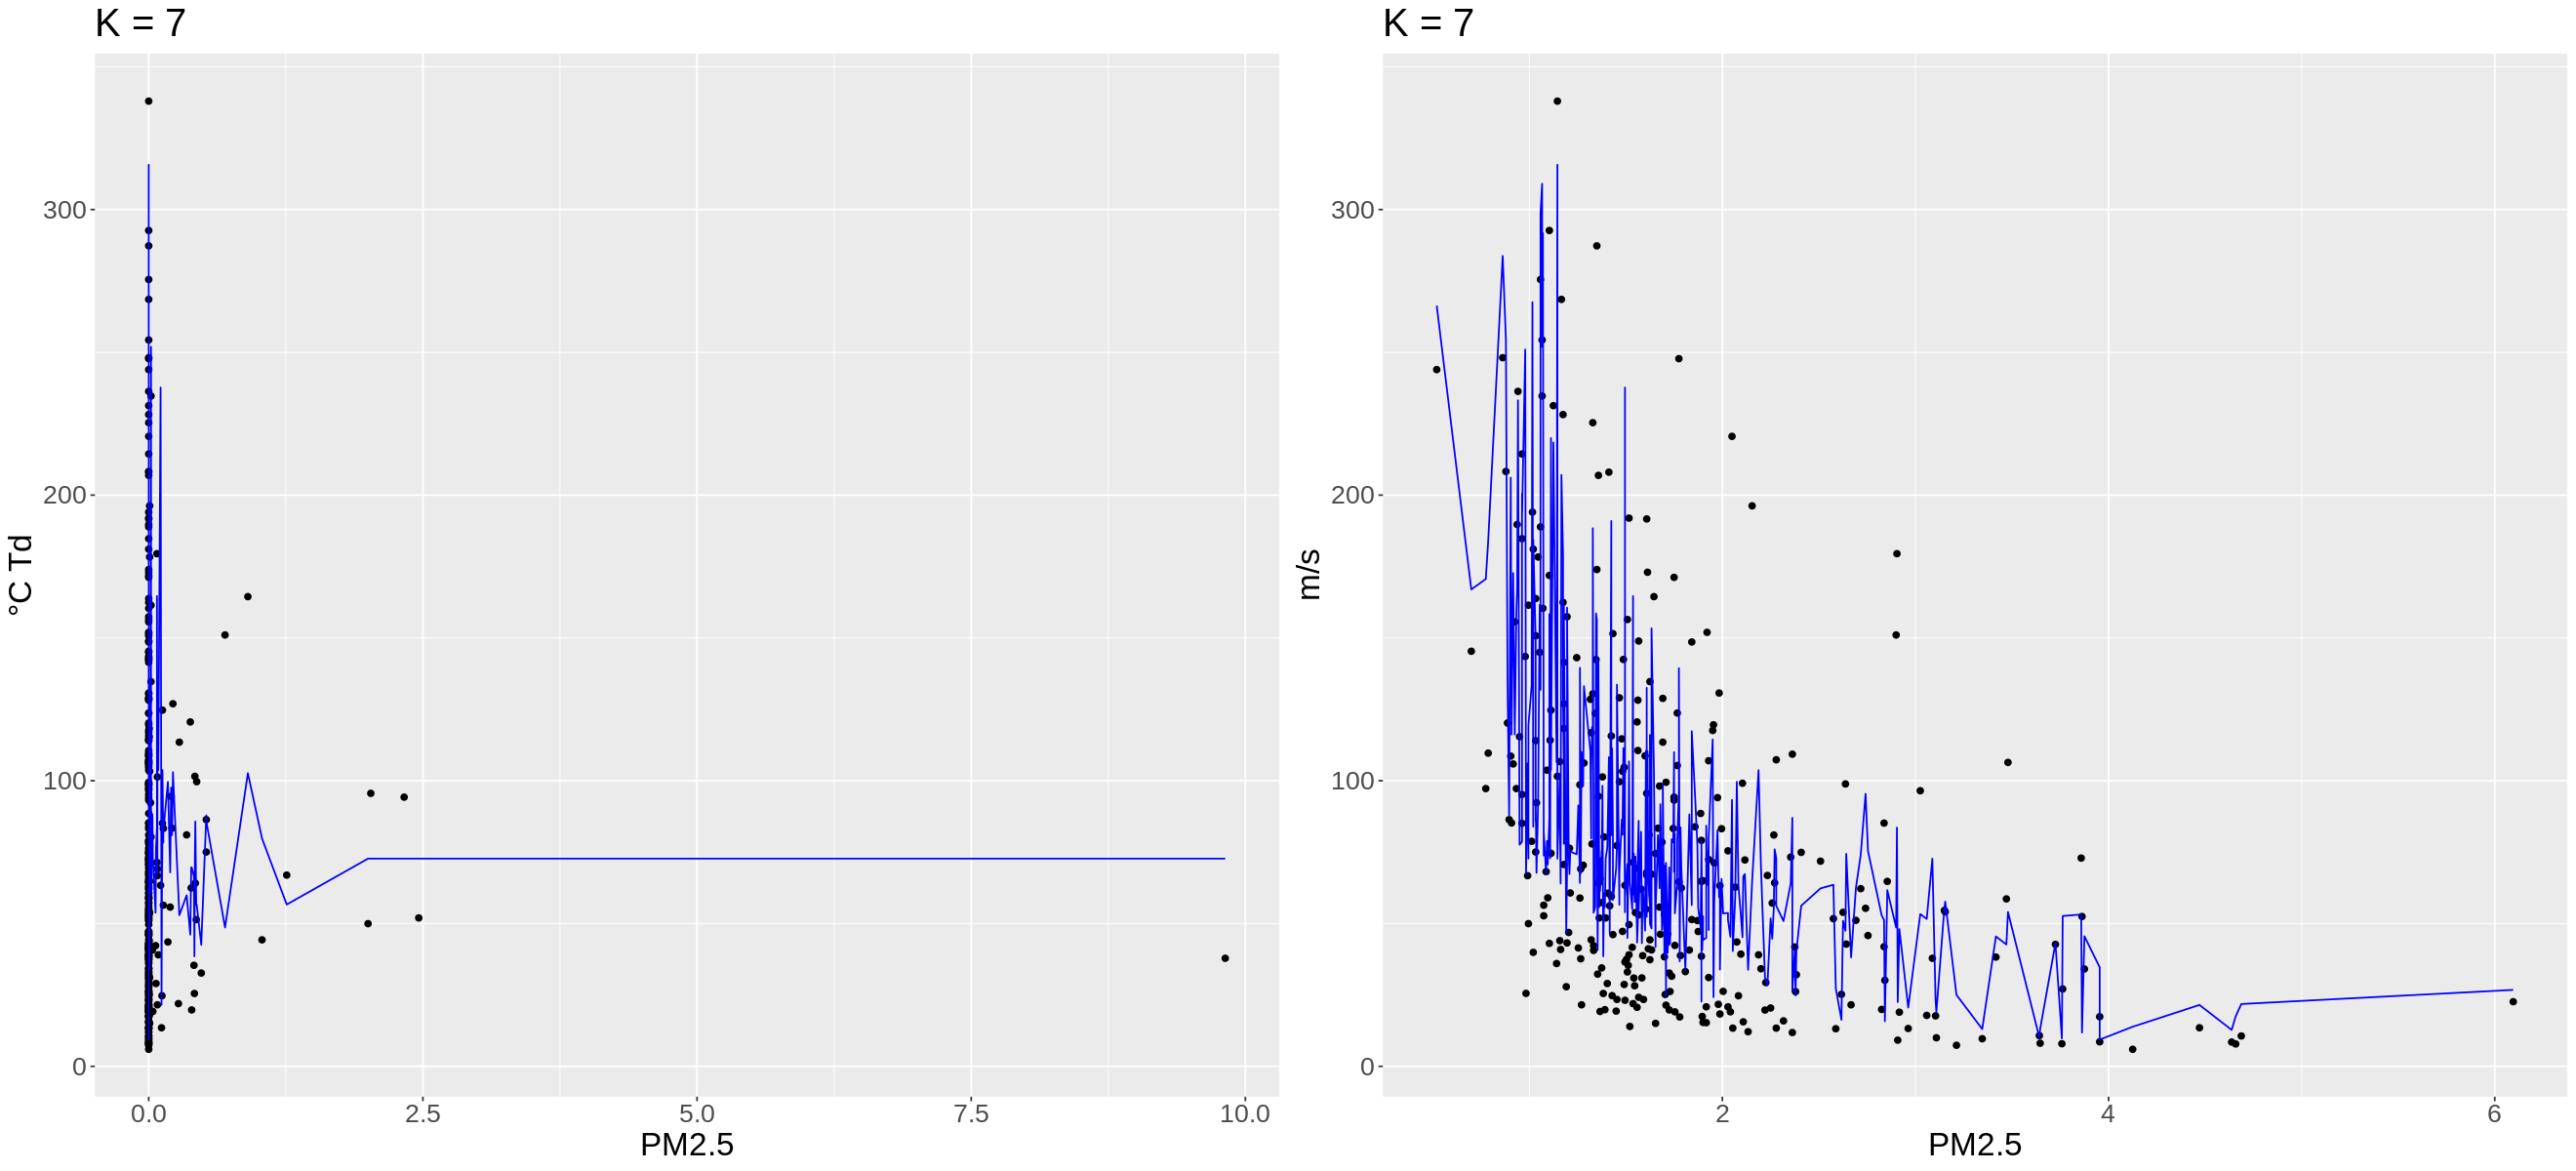

In [24]:
weather_preds <- predict(weather_best_fit, weather_testing) |>
bind_cols(weather_testing)
weather_preds

temp_plot <- ggplot(weather_preds, aes(x = TEMP, y = PM2.5)) +
    geom_point() +
    geom_line(data = weather_preds,
              mapping = aes(x = TEMP, y = .pred),
              color = "blue") +
    xlab("PM2.5") + 
    ylab("Celcius") +
    ggtitle(paste0("K = ", k_min)) + 
    theme(text = element_text(size = 20))

pressure_plot <- ggplot(weather_preds, aes(x = PRES, y = PM2.5)) +
    geom_point() +
    geom_line(data = weather_preds,
              mapping = aes(x = PRES, y = .pred),
              color = "blue") +
    xlab("PM2.5") + 
    ylab("Pascal") +
    ggtitle(paste0("K = ", k_min)) + 
    theme(text = element_text(size = 20))

dewp_plot <- ggplot(weather_preds, aes(x = DEWP, y = PM2.5)) +
    geom_point() +
    geom_line(data = weather_preds,
              mapping = aes(x = DEWP, y = .pred),
              color = "blue") +
    xlab("PM2.5") + 
    ylab("°C Td") +
    ggtitle(paste0("K = ", k_min)) + 
    theme(text = element_text(size = 20))

rain_plot <- ggplot(weather_preds, aes(x = RAIN, y = PM2.5)) +
    geom_point() +
    geom_line(data = weather_preds,
              mapping = aes(x = RAIN, y = .pred),
              color = "blue") +
    xlab("PM2.5") + 
    ylab("°C Td") +
    ggtitle(paste0("K = ", k_min)) + 
    theme(text = element_text(size = 20))

wspm_plot <- ggplot(weather_preds, aes(x = WSPM, y = PM2.5)) +
    geom_point() +
    geom_line(data = weather_preds,
              mapping = aes(x = WSPM, y = .pred),
              color = "blue") +
    xlab("PM2.5") + 
    ylab("m/s") +
    ggtitle(paste0("K = ", k_min)) + 
    theme(text = element_text(size = 20))

options(repr.plot.width = 22)
panel1 <- plot_grid(temp_plot, 
                   pressure_plot, 
                   dewp_plot,
                    ncol = 3)

panel2 <- plot_grid(rain_plot, 
                   wspm_plot,
                   ncol = 2)
                   
panel1
panel2

**ELABORATE**

### Discussion
1. What do you expect to find?

- We expect to find a correlation between certain meteorological conditions and the quantity of certain air pollutants, while also finding differences between the manner in which different types of air pollutants react to different conditions. For example, gaseous pollutants may not be affected as much by precipitation as particulate matter, while gaseous pollutants may be more affected by wind speed.

2. What impact could such findings have?
- Discovering the relationship between air pollutants and weather conditions may provide insight into methods of mitigating the effects of air pollution. This can help to advance active pollution reduction technologies such as carbon capture or discovering better methods of reducing the penetration of PM 2.5 into households. Since we can tentatively predict the weather, we may be able to use meteorology combined with behavioral techniques to reduce air pollution such as by using green energy during periods of low wind speed.

3. What future questions could this lead to?
- Is the air pollution temporarily reduced or permanently removed from the air through weather events?
**The pollutant, PM 2.5, may be integrated into the environment such as how smoke is washed into the soil and turned into ash.**

- Does the pollution from air pollution become integrated into the environment through other means such as water pollution?
**Certain types of toxic pollutants may be washed into the water supply, such as meteorological conditions such as acid rain.**

- How might meteorological conditions be stimulated or controlled to reduce air pollution in cities?
**Techniques such as rain cloud seeding may be available to reduce the concentration of pollutants during high concentration of pollutants.**


### References